# Задача

Нам предложено 10 жанров и по 100 аудизаписей к ним. Мы будем создавать фичи для этих данных и предсказывать по ним жанр.

# Импорт и подготовка данных

In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import soundfile as sf
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import keras as k
from keras.models import Sequential
from sklearn.metrics import f1_score

In [2]:
RANDOM_STATE = 101

In [2]:
import warnings
warnings.filterwarnings("ignore", message="Trying to estimate tuning from empty frequency set.")

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
way = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/"

In [5]:
genres = os.listdir(way)

In [6]:
music = {}
for genre in genres:
    music[genre] = os.listdir(way+genre)

In [7]:
len(music), len(music[genre])

(10, 100)

# Создание датасетов

## Первый способ 

В предложенном датасете у нас есть таблица с параметры, мы создали функцию, которая скорее всего достаёт из аудио те же параметры, которые заявлены в датасете. Из этого мы создадим свой датасет.

In [ ]:
def extract_features(track):
    y, sr = librosa.load(track)
    
    #Вычисление признаков
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    #Creating a dictionary to store the features
    feature_set = {}
    feature_set['chroma_stft_mean'] = np.mean(chroma_stft)
    feature_set['chroma_stft_var'] = np.var(chroma_stft)
    feature_set['rms_mean'] = np.mean(rms)
    feature_set['rms_var'] = np.var(rms)
    feature_set['spectral_centroid_mean'] = np.mean(spec_cent)
    feature_set['spectral_centroid_var'] = np.var(spec_cent)
    feature_set['spectral_bandwidth_mean'] = np.mean(spec_bw)
    feature_set['spectral_bandwidth_var'] = np.var(spec_bw)
    feature_set['rolloff_mean'] = np.mean(rolloff)
    feature_set['rolloff_var'] = np.var(rolloff)
    feature_set['zero_crossing_rate_mean'] = np.mean(zcr)
    feature_set['zero_crossing_rate_var'] = np.var(zcr)
    feature_set['tempo'] = tempo
    
    # MFCCs
    for e in range(1,21):
        feature_set[f'mfcc{e}_mean'] = np.mean(mfcc[e-1])
        feature_set[f'mfcc{e}_var'] = np.var(mfcc[e-1])
    
    return feature_set

In [ ]:
def create_dataframe(music, way=way):
    df = pd.DataFrame()
    for genre, files in music.items():
        for file in tqdm(files, desc=genre):
            try:
                features = extract_features(way+genre+'/'+file)
                features['genre'] = genre
                features = pd.DataFrame(data=[list(features.values())], columns=list(features.keys()))
                df = pd.concat([df, features])
            except:
                print('ERROR reading:')
                print(way+genre+'/'+file)
    return df

In [ ]:
data = create_dataframe(music, way)
data.to_csv('gotten_features.csv', index=False)

In [8]:
pd.read_csv('/kaggle/input/gotten-features/gotten_features.csv')

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.417180,0.083849,0.115737,0.002511,3256.824592,3.885835e+05,2898.247907,93275.687126,6681.488136,1.590228e+06,...,46.898810,-4.377054,38.717290,-3.651327,49.481274,-2.090353,55.316196,-0.312381,57.221195,disco
1,0.429750,0.078049,0.100293,0.001004,2128.932662,3.264302e+05,2108.898696,157527.878978,4423.058147,1.696890e+06,...,37.090675,-10.314117,38.484943,0.569395,42.171764,-4.152319,62.857390,3.473263,61.314556,disco
2,0.452995,0.086779,0.084745,0.001776,2292.343239,4.291668e+05,2348.257608,97938.168642,5038.586341,1.787596e+06,...,43.245407,-0.305486,62.860863,7.588761,65.560640,0.653866,64.575230,0.800320,70.429040,disco
3,0.450119,0.079885,0.169938,0.004638,3167.957020,6.708824e+05,3047.751585,80129.502168,6935.539964,1.698825e+06,...,33.427406,-4.745715,31.178467,-5.765583,25.345272,-4.028948,25.122086,-5.362669,24.810057,disco
4,0.434904,0.079379,0.114454,0.001662,1974.507688,3.510581e+05,2089.631458,180506.795524,4249.843263,1.961304e+06,...,41.146393,-8.090049,36.751960,0.366702,43.388584,-3.236822,56.369453,3.578942,61.412624,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.346430,0.099927,0.169049,0.012295,3647.914741,1.088222e+06,2886.918952,188186.990366,7113.759278,2.336344e+06,...,189.863250,9.384047,215.372820,5.288314,243.659940,-2.936134,166.262120,-5.576417,104.710720,pop
995,0.407417,0.093937,0.245588,0.013581,3262.988839,1.228202e+06,2931.274189,192677.410498,6715.594865,3.537183e+06,...,81.932500,-0.427179,74.217766,-4.024591,71.820490,4.379017,125.612580,4.464227,119.344330,pop
996,0.282345,0.090407,0.083315,0.001238,2053.421991,6.862796e+05,2559.297984,158101.285466,4506.526372,3.431300e+06,...,102.325490,-7.758934,134.617420,-5.142255,181.577000,-1.824658,159.390990,-4.419271,166.375700,pop
997,0.413989,0.092016,0.208303,0.006605,3046.523748,1.375435e+06,3095.301264,187018.600181,6630.777693,3.860326e+06,...,54.386734,-0.960986,52.948994,-1.017271,56.505733,-0.468818,52.956560,-0.751563,66.910950,pop


В следствии того, что некоторые аудиозаписи привели к ошибке, наш датасет сократился. (-1)

## Второй способ 

В данном случае мы извлекаем из аудио коэффициенты MFCC - это характеристики, которые представляют собой компактное представление аудио сигнала, содержащее информацию о его спектральных и частотных характеристиках.

In [ ]:
def extract_features(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    return mfccs.reshape(1,-1)[0]

In [ ]:
def create_dataframe(music, way=way):
    X = None
    y = None
    for genre, files in music.items():
        for file in tqdm(files, desc=genre):
            if X is None and y is None:
                features = extract_features(way+genre+'/'+file)
                X = features
                y = np.array([genre])
            try:
                features = extract_features(way+genre+'/'+file)
                X = np.vstack((X, features))
                y = np.vstack((y, genre))
            except:
                pass
    return X, y

In [12]:
X, y = create_dataframe(music, way=way)

jazz:  26%|██▌       | 26/100 [00:04<00:11,  6.25it/s]/tmp/ipykernel_32/1964496284.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
pop: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


In [13]:
X.shape, y.shape

((945, 51720), (945, 1))

In [15]:
np.save('gotten_target.npy', y)

In [17]:
np.save('gotten_features.npy', X)

In [9]:
X = np.load('/kaggle/input/gotten-features-2way/gotten_features.npy')
y = np.load('/kaggle/input/gotten-features-2way/gotten_target.npy')

In [10]:
X

array([[-2.2435786e+02, -1.9973849e+02, -1.8620123e+02, ...,
        -7.6109499e-01, -6.0789456e+00, -6.8409853e+00],
       [-2.2435786e+02, -1.9973849e+02, -1.8620123e+02, ...,
        -7.6109499e-01, -6.0789456e+00, -6.8409853e+00],
       [-1.3239122e+02, -1.2811646e+02, -1.6130894e+02, ...,
        -1.0253139e+00,  1.4601707e+00,  5.5019355e-01],
       ...,
       [-2.5239201e+02, -2.3837393e+02, -2.5186000e+02, ...,
        -9.8699846e+00, -3.3858376e+00,  1.5288150e+00],
       [-2.3274675e+02, -1.2548463e+02, -5.6231228e+01, ...,
        -1.8046986e+01, -1.3794443e+01, -7.5599127e+00],
       [-1.1081313e+02, -1.2659299e+01, -3.3940897e+00, ...,
        -3.3939757e+00, -5.2670002e-02,  5.1372278e-01]], dtype=float32)

## Третий способ 

In [8]:
def extract_features(track):
    y, sr = librosa.load(track)
    
    #Вычисление признаков
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    
    #Creating a dictionary to store the features
    feature_set = {}
    feature_set['chroma_stft_mean'] = np.mean(chroma_stft)
    feature_set['chroma_stft_var'] = np.var(chroma_stft)
    feature_set['rms_mean'] = np.mean(rms)
    feature_set['rms_var'] = np.var(rms)
    feature_set['spectral_centroid_mean'] = np.mean(spec_cent)
    feature_set['spectral_centroid_var'] = np.var(spec_cent)
    feature_set['spectral_bandwidth_mean'] = np.mean(spec_bw)
    feature_set['spectral_bandwidth_var'] = np.var(spec_bw)
    feature_set['rolloff_mean'] = np.mean(rolloff)
    feature_set['rolloff_var'] = np.var(rolloff)
    feature_set['zero_crossing_rate_mean'] = np.mean(zcr)
    feature_set['zero_crossing_rate_var'] = np.var(zcr)
    feature_set['tempo'] = tempo
    
    # MFCCs
    for e in range(1,21):
        feature_set[f'mfcc{e}_mean'] = np.mean(mfcc[e-1])
        feature_set[f'mfcc{e}_var'] = np.var(mfcc[e-1])
    
    return feature_set

In [9]:
def process_audio(file, chunk_length=5):
    y, sr = librosa.load(file, sr=None)
    chunk_samples = chunk_length * sr
    total_samples = len(y)
    features = []
    for i in range(0, total_samples, chunk_samples):
        chunk = y[i:i + chunk_samples]
        sf.write('temp_chunk.wav', chunk, sr)
        chunk_features = extract_features('temp_chunk.wav')
        features.append(chunk_features)
    os.remove('temp_chunk.wav')
    df = pd.DataFrame(features)
    return df

In [10]:
def create_dataframe(music, way=way):
    df = pd.DataFrame()
    for genre, files in music.items():
        for file in tqdm(files, desc=genre):
            try:
                features = process_audio(way+genre+'/'+file)
                features['genre'] = genre
                df = pd.concat([df, features])
            except:
                pass
    return df

In [11]:
%%time
data = create_dataframe(music, way)

pop: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

CPU times: user 47min 57s, sys: 39min 51s, total: 1h 27min 48s
Wall time: 22min 57s


In [12]:
data.to_csv('gotten_features_way3.csv', index=False)

In [13]:
data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.312652,0.091468,0.090109,0.001079,3391.651631,5.788741e+05,2937.782040,127468.493125,6841.975911,2.088618e+06,...,73.044708,-7.808761,71.420937,-10.312478,62.829556,-1.726780,87.190498,1.003157,122.017982,disco
1,0.367956,0.093702,0.156652,0.003488,3106.905614,1.851379e+05,2762.345097,49396.518892,6179.580688,1.048732e+06,...,54.501419,-2.038537,40.174484,-2.489890,74.166206,2.210460,85.864738,1.238705,61.353519,disco
2,0.468170,0.075007,0.109297,0.001547,3177.728893,2.263534e+05,2831.043509,58751.091038,6552.224731,1.108973e+06,...,23.585621,-4.007629,23.485058,-2.172202,23.752096,-2.165016,27.929846,-0.393007,31.962477,disco
3,0.464076,0.072439,0.102249,0.001726,3359.845223,3.872032e+05,2923.078409,95959.241809,6855.683390,1.656232e+06,...,16.980583,-5.228517,22.865438,-3.008909,18.711296,-4.916043,27.006628,-3.085462,36.021027,disco
4,0.427732,0.075083,0.117539,0.002785,3299.261773,5.463638e+05,2962.220557,119777.046177,6838.137817,1.990120e+06,...,42.289143,-3.614397,28.733873,-2.002331,29.370424,-2.077155,40.169941,-0.670792,32.704903,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.401797,0.089903,0.104835,0.001689,4394.833619,1.716762e+06,3457.003168,63421.109902,8785.945638,1.173613e+06,...,57.183914,-3.099098,62.551678,0.190363,87.597565,-0.486930,109.589050,4.623295,103.593193,pop
3,0.447921,0.085639,0.092948,0.002507,4195.237414,2.095589e+06,3416.375277,113027.137533,8454.174805,2.447367e+06,...,45.666611,-0.074809,88.792336,0.487066,131.876755,-1.380745,108.027397,0.035173,85.600792,pop
4,0.421249,0.078993,0.109788,0.002173,3900.404791,8.189538e+05,3294.079211,75049.841472,8102.067057,1.490589e+06,...,28.760862,0.120418,22.630140,-2.219404,25.862373,-1.207537,29.748293,-1.224777,31.463770,pop
5,0.441734,0.079261,0.104121,0.001759,4023.879195,9.667005e+05,3299.551913,48653.008742,8214.019775,1.054758e+06,...,41.192406,1.141576,50.274796,-0.187689,55.341034,-0.111707,57.924595,1.911272,48.447754,pop


# Разделение данных

## Данные 1 способа 

In [3]:
data_1 = pd.read_csv('/kaggle/input/gotten-features/gotten_features.csv')

In [4]:
data_1

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.417180,0.083849,0.115737,0.002511,3256.824592,3.885835e+05,2898.247907,93275.687126,6681.488136,1.590228e+06,...,46.898810,-4.377054,38.717290,-3.651327,49.481274,-2.090353,55.316196,-0.312381,57.221195,disco
1,0.429750,0.078049,0.100293,0.001004,2128.932662,3.264302e+05,2108.898696,157527.878978,4423.058147,1.696890e+06,...,37.090675,-10.314117,38.484943,0.569395,42.171764,-4.152319,62.857390,3.473263,61.314556,disco
2,0.452995,0.086779,0.084745,0.001776,2292.343239,4.291668e+05,2348.257608,97938.168642,5038.586341,1.787596e+06,...,43.245407,-0.305486,62.860863,7.588761,65.560640,0.653866,64.575230,0.800320,70.429040,disco
3,0.450119,0.079885,0.169938,0.004638,3167.957020,6.708824e+05,3047.751585,80129.502168,6935.539964,1.698825e+06,...,33.427406,-4.745715,31.178467,-5.765583,25.345272,-4.028948,25.122086,-5.362669,24.810057,disco
4,0.434904,0.079379,0.114454,0.001662,1974.507688,3.510581e+05,2089.631458,180506.795524,4249.843263,1.961304e+06,...,41.146393,-8.090049,36.751960,0.366702,43.388584,-3.236822,56.369453,3.578942,61.412624,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.346430,0.099927,0.169049,0.012295,3647.914741,1.088222e+06,2886.918952,188186.990366,7113.759278,2.336344e+06,...,189.863250,9.384047,215.372820,5.288314,243.659940,-2.936134,166.262120,-5.576417,104.710720,pop
995,0.407417,0.093937,0.245588,0.013581,3262.988839,1.228202e+06,2931.274189,192677.410498,6715.594865,3.537183e+06,...,81.932500,-0.427179,74.217766,-4.024591,71.820490,4.379017,125.612580,4.464227,119.344330,pop
996,0.282345,0.090407,0.083315,0.001238,2053.421991,6.862796e+05,2559.297984,158101.285466,4506.526372,3.431300e+06,...,102.325490,-7.758934,134.617420,-5.142255,181.577000,-1.824658,159.390990,-4.419271,166.375700,pop
997,0.413989,0.092016,0.208303,0.006605,3046.523748,1.375435e+06,3095.301264,187018.600181,6630.777693,3.860326e+06,...,54.386734,-0.960986,52.948994,-1.017271,56.505733,-0.468818,52.956560,-0.751563,66.910950,pop


In [7]:
X_1 = data_1.drop(['genre'], axis = 1)
y_1 = data_1['genre']

In [8]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.35, random_state=RANDOM_STATE)

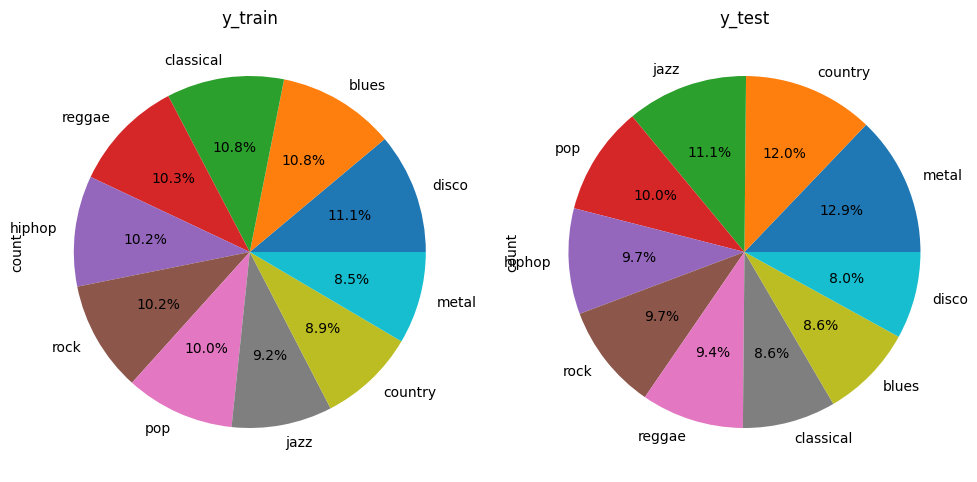

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
y_train_1.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_title('y_train') 
y_test_1.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_title('y_test')
plt.tight_layout()
plt.show()

In [10]:
labelcod_1 = LabelEncoder()
y_train_1 = labelcod_1.fit_transform(y_train_1)
y_test_1 = labelcod_1.fit_transform(y_test_1)
sscaler_1 = StandardScaler()
X_train_1 = sscaler_1.fit_transform(X_train_1)
X_test_1 = sscaler_1.transform(X_test_1)

## Данные 2 способа 

In [11]:
X_2 = np.load('/kaggle/input/gotten-features-2way/gotten_features.npy')
y_2 = np.load('/kaggle/input/gotten-features-2way/gotten_target.npy')

In [12]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.35, random_state=RANDOM_STATE)

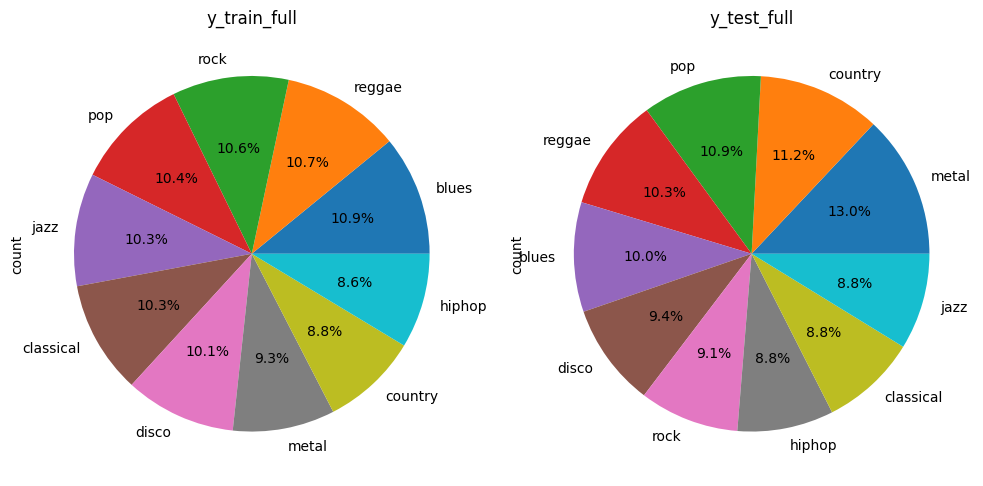

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
pd.Series(y_train_2.ravel()).value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_title('y_train_full') 
pd.Series(y_test_2.ravel()).value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_title('y_test_full')
plt.tight_layout()
plt.show()

In [15]:
labelcod_2 = LabelEncoder()
y_train_2 = labelcod_2.fit_transform(y_train_2)
y_test_2 = labelcod_2.fit_transform(y_test_2)
sscaler_2 = StandardScaler()
X_train_2 = sscaler_2.fit_transform(X_train_2)
X_test_2 = sscaler_2.transform(X_test_2)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Данные 3 способа 

In [16]:
data_3 = pd.read_csv('/kaggle/input/gotten-features-way3/gotten_features_way3.csv')

In [17]:
data_3

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.312652,0.091468,0.090109,0.001079,3391.651631,5.788741e+05,2937.782040,127468.493125,6841.975911,2.088618e+06,...,73.044710,-7.808761,71.420940,-10.312478,62.829556,-1.726780,87.190500,1.003157,122.017980,disco
1,0.367956,0.093702,0.156652,0.003488,3106.905614,1.851379e+05,2762.345097,49396.518892,6179.580688,1.048732e+06,...,54.501420,-2.038537,40.174484,-2.489890,74.166210,2.210460,85.864740,1.238705,61.353520,disco
2,0.468170,0.075007,0.109297,0.001547,3177.728893,2.263534e+05,2831.043509,58751.091038,6552.224731,1.108973e+06,...,23.585620,-4.007629,23.485058,-2.172202,23.752096,-2.165016,27.929846,-0.393007,31.962477,disco
3,0.464076,0.072439,0.102249,0.001726,3359.845223,3.872032e+05,2923.078409,95959.241809,6855.683390,1.656232e+06,...,16.980583,-5.228517,22.865438,-3.008910,18.711296,-4.916043,27.006628,-3.085462,36.021027,disco
4,0.427732,0.075083,0.117539,0.002785,3299.261773,5.463638e+05,2962.220557,119777.046177,6838.137817,1.990120e+06,...,42.289143,-3.614397,28.733873,-2.002330,29.370424,-2.077155,40.169940,-0.670792,32.704903,disco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6978,0.401797,0.089903,0.104835,0.001689,4394.833619,1.716762e+06,3457.003168,63421.109902,8785.945638,1.173613e+06,...,57.183914,-3.099098,62.551678,0.190363,87.597565,-0.486930,109.589050,4.623295,103.593190,pop
6979,0.447921,0.085639,0.092948,0.002507,4195.237414,2.095589e+06,3416.375277,113027.137533,8454.174805,2.447367e+06,...,45.666610,-0.074809,88.792336,0.487066,131.876750,-1.380745,108.027400,0.035173,85.600790,pop
6980,0.421249,0.078993,0.109788,0.002173,3900.404791,8.189538e+05,3294.079211,75049.841472,8102.067057,1.490589e+06,...,28.760862,0.120418,22.630140,-2.219404,25.862373,-1.207537,29.748293,-1.224777,31.463770,pop
6981,0.441734,0.079261,0.104121,0.001759,4023.879195,9.667005e+05,3299.551913,48653.008742,8214.019775,1.054758e+06,...,41.192406,1.141576,50.274796,-0.187689,55.341034,-0.111707,57.924595,1.911272,48.447754,pop


In [18]:
X_3 = data_3.drop(['genre'], axis = 1)
y_3 = data_3['genre']

In [19]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.35, random_state=RANDOM_STATE)

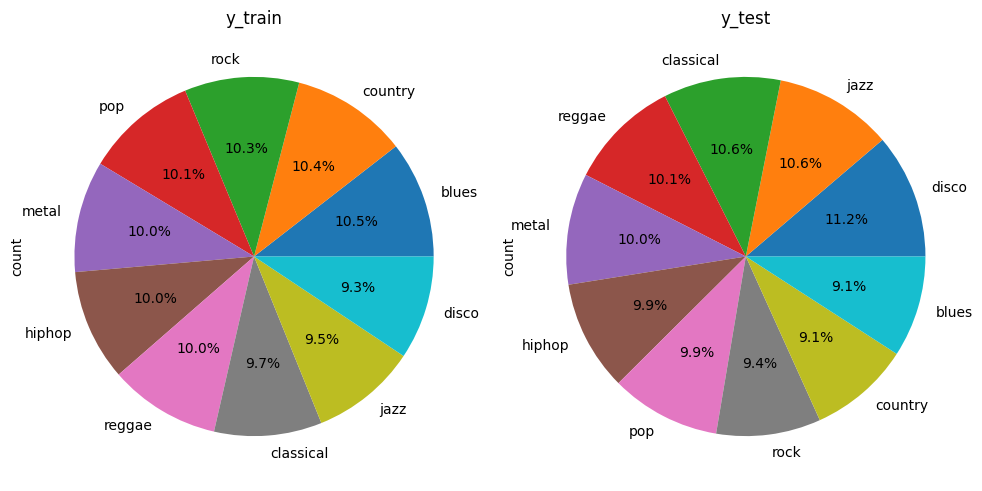

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
y_train_3.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_title('y_train') 
y_test_3.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_title('y_test')
plt.tight_layout()
plt.show()

In [21]:
labelcod_3 = LabelEncoder()
y_train_3 = labelcod_3.fit_transform(y_train_3)
y_test_3 = labelcod_3.fit_transform(y_test_3)
sscaler_3 = StandardScaler()
X_train_3 = sscaler_3.fit_transform(X_train_3)
X_test_3 = sscaler_3.transform(X_test_3)

# Обучение

## CNN 

In [22]:
def trainModel(model, 
               X_train, 
               y_train, 
               X_test, 
               y_test, 
               batch_size = 128, 
               epochs=10, 
               loss='sparse_categorical_crossentropy', 
               metrics='accuracy', 
               optimizer='adam'):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

### Данные 1 способа 

In [23]:
cnnmodel_1 = k.models.Sequential([
    k.layers.Reshape((len(X_train_1[0]), 1), input_shape=(len(X_train_1[0]),)),
    k.layers.Conv1D(64, kernel_size=3, activation='relu'),  
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Conv1D(128, kernel_size=3, activation='relu'), 
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Flatten(),  
    k.layers.Dense(128, activation='relu'),  
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'), 
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax')
])
print(cnnmodel_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 53, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 128)          0         
 1D)                                                    

In [24]:
trainModel(cnnmodel_1, X_train_1, y_train_1, X_test_1, y_test_1, epochs=30)

Epoch 1/30
6/6 [==============================] - 2s 86ms/step - loss: 2.2625 - accuracy: 0.1710 - val_loss: 2.1567 - val_accuracy: 0.2429
Epoch 2/30
6/6 [==============================] - 0s 30ms/step - loss: 2.1153 - accuracy: 0.2604 - val_loss: 2.0100 - val_accuracy: 0.3143
Epoch 3/30
6/6 [==============================] - 0s 28ms/step - loss: 1.9708 - accuracy: 0.2943 - val_loss: 1.8580 - val_accuracy: 0.3800
Epoch 4/30
6/6 [==============================] - 0s 26ms/step - loss: 1.8127 - accuracy: 0.3790 - val_loss: 1.7552 - val_accuracy: 0.3600
Epoch 5/30
6/6 [==============================] - 0s 27ms/step - loss: 1.7006 - accuracy: 0.3898 - val_loss: 1.6635 - val_accuracy: 0.4029
Epoch 6/30
6/6 [==============================] - 0s 29ms/step - loss: 1.6539 - accuracy: 0.3945 - val_loss: 1.5811 - val_accuracy: 0.4171
Epoch 7/30
6/6 [==============================] - 0s 28ms/step - loss: 1.6047 - accuracy: 0.4191 - val_loss: 1.5194 - val_accuracy: 0.4371
Epoch 8/30
6/6 [===========

In [25]:
test_loss, test_acc = cnnmodel_1.evaluate(X_test_1, y_test_1, batch_size=128)
pred = cnnmodel_1.predict(X_test_1)
class_predictions = np.argmax(pred, axis=1)
test_f1 = f1_score(y_test_1, class_predictions, average='macro')

11/11 [==============================] - 0s 5ms/step


In [26]:
import time

def measure_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    return round(end_time - start_time, 4)

results = [['type', 'way', 'test_loss', 'test_acc', 'test_f1', 'time.pred']]

In [27]:
results.append(['cnn',
                '1',
                round(test_loss, 4),
                round(test_acc, 4),
                round(test_f1, 4), 
                round(measure_time(cnnmodel_1.predict, X_test_1)/len(X_test_1), 4)])

11/11 [==============================] - 0s 4ms/step


In [28]:
results

[['type', 'way', 'test_loss', 'test_acc', 'test_f1', 'time.pred'],
 ['cnn', '1', 1.0781, 0.6571, 0.6474, 0.0004]]

### Данные 2 способа 

In [29]:
cnnmodel_2 = k.models.Sequential([
    k.layers.Reshape((len(X_train_2[0]), 1), input_shape=(len(X_train_2[0]),)),
    k.layers.Conv1D(64, kernel_size=3, activation='relu'),  
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Conv1D(128, kernel_size=3, activation='relu'), 
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Flatten(),  
    k.layers.Dense(128, activation='relu'),  
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'), 
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax')
])
print(cnnmodel_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 51720, 1)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 51718, 64)         256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25859, 64)        0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25859, 64)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 25857, 128)        24704     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12928, 128)       0         
 1D)                                                  

In [30]:
trainModel(cnnmodel_2, X_train_2, y_train_2, X_test_2, y_test_2)

Epoch 1/10
5/5 [==============================] - 130s 26s/step - loss: 31.1411 - accuracy: 0.1010 - val_loss: 7.8163 - val_accuracy: 0.2236
Epoch 2/10
5/5 [==============================] - 124s 25s/step - loss: 12.8427 - accuracy: 0.1612 - val_loss: 2.3863 - val_accuracy: 0.2054
Epoch 3/10
5/5 [==============================] - 126s 26s/step - loss: 3.1750 - accuracy: 0.2394 - val_loss: 2.0193 - val_accuracy: 0.3293
Epoch 4/10
5/5 [==============================] - 126s 25s/step - loss: 1.9726 - accuracy: 0.3111 - val_loss: 2.1944 - val_accuracy: 0.2236
Epoch 5/10
5/5 [==============================] - 124s 25s/step - loss: 2.0334 - accuracy: 0.2948 - val_loss: 2.2089 - val_accuracy: 0.2991
Epoch 6/10
5/5 [==============================] - 154s 31s/step - loss: 2.0461 - accuracy: 0.3339 - val_loss: 2.1714 - val_accuracy: 0.3535
Epoch 7/10
5/5 [==============================] - 124s 25s/step - loss: 1.9751 - accuracy: 0.3502 - val_loss: 2.0728 - val_accuracy: 0.3625
Epoch 8/10
5/5 [==

In [31]:
test_loss, test_acc = cnnmodel_2.evaluate(X_test_2, y_test_2, batch_size=128)
pred = cnnmodel_2.predict(X_test_2)
class_predictions = np.argmax(pred, axis=1)
test_f1 = f1_score(y_test_2, class_predictions, average='macro')

11/11 [==============================] - 29s 3s/step


In [32]:
results.append(['cnn',
                '2',
                round(test_loss, 4),
                round(test_acc, 4),
                round(test_f1, 4), 
                round(measure_time(cnnmodel_2.predict, X_test_2)/len(X_test_2), 4)])

11/11 [==============================] - 14s 1s/step


### Данные 3 способа

In [33]:
cnnmodel_3 = k.models.Sequential([
    k.layers.Reshape((len(X_train_3[0]), 1), input_shape=(len(X_train_3[0]),)),
    k.layers.Conv1D(64, kernel_size=3, activation='relu'),  
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Conv1D(128, kernel_size=3, activation='relu'), 
    k.layers.MaxPooling1D(pool_size=2),  
    k.layers.Dropout(0.2),
    k.layers.Flatten(),  
    k.layers.Dense(128, activation='relu'),  
    k.layers.Dropout(0.2),
    k.layers.Dense(64, activation='relu'), 
    k.layers.Dropout(0.2),
    k.layers.Dense(10, activation='softmax')
])
print(cnnmodel_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 53, 1)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 51, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 25, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 23, 128)           24704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 11, 128)          0         
 1D)                                                  

In [34]:
trainModel(cnnmodel_3, X_train_3, y_train_3, X_test_3, y_test_3, epochs=30)

Epoch 1/30
36/36 [==============================] - 2s 33ms/step - loss: 2.0448 - accuracy: 0.2704 - val_loss: 1.6885 - val_accuracy: 0.3816
Epoch 2/30
36/36 [==============================] - 1s 27ms/step - loss: 1.6635 - accuracy: 0.3925 - val_loss: 1.4529 - val_accuracy: 0.4802
Epoch 3/30
36/36 [==============================] - 1s 27ms/step - loss: 1.4807 - accuracy: 0.4775 - val_loss: 1.3100 - val_accuracy: 0.5292
Epoch 4/30
36/36 [==============================] - 1s 30ms/step - loss: 1.3696 - accuracy: 0.5086 - val_loss: 1.2404 - val_accuracy: 0.5607
Epoch 5/30
36/36 [==============================] - 1s 29ms/step - loss: 1.2788 - accuracy: 0.5392 - val_loss: 1.1694 - val_accuracy: 0.5845
Epoch 6/30
36/36 [==============================] - 1s 27ms/step - loss: 1.2109 - accuracy: 0.5712 - val_loss: 1.1030 - val_accuracy: 0.6074
Epoch 7/30
36/36 [==============================] - 1s 27ms/step - loss: 1.1511 - accuracy: 0.5890 - val_loss: 1.0660 - val_accuracy: 0.6335
Epoch 8/30
36

In [35]:
test_loss, test_acc = cnnmodel_3.evaluate(X_test_3, y_test_3, batch_size=128)
pred = cnnmodel_3.predict(X_test_3)
class_predictions = np.argmax(pred, axis=1)
test_f1 = f1_score(y_test_3, class_predictions, average='macro')

77/77 [==============================] - 0s 4ms/step


In [36]:
results.append(['cnn',
                '3',
                round(test_loss, 4),
                round(test_acc, 4),
                round(test_f1, 4), 
                round(measure_time(cnnmodel_3.predict, X_test_3)/len(X_test_3), 4)])

77/77 [==============================] - 0s 4ms/step


In [37]:
results

[['type', 'way', 'test_loss', 'test_acc', 'test_f1', 'time.pred'],
 ['cnn', '1', 1.0781, 0.6571, 0.6474, 0.0004],
 ['cnn', '2', 1.6228, 0.4683, 0.4146, 0.0436],
 ['cnn', '3', 0.7426, 0.7403, 0.7386, 0.0002]]

## Бустинг 

In [38]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

### Данные 1 способа 

In [39]:
lgbm_1 = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_1.fit(X_train_1, y_train_1)
lgbm_pred = lgbm_1.predict(X_test_1)

In [40]:
results.append(['lgbm', 
                  '1', 
                  '-', 
                  round(accuracy_score(y_test_1, lgbm_pred), 4), 
                  round(f1_score(y_test_1, lgbm_pred, average='macro'), 4),
                  round(measure_time(lgbm_1.predict, X_test_1), 4)])

### Данные 2 способа 

In [98]:
lgbm_2 = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_2.fit(X_train_2, y_train_2)
lgbm_pred = lgbm_2.predict(X_test_2)

In [99]:
results.append(['lgbm', 
                  '2', 
                  '-', 
                  round(accuracy_score(y_test_2, lgbm_pred), 4), 
                  round(f1_score(y_test_2, lgbm_pred, average='macro'), 4),
                  round(measure_time(lgbm_2.predict, X_test_2), 4)])

### Данные 3 способа

In [45]:
lgbm_3 = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_3.fit(X_train_3, y_train_3)
lgbm_pred = lgbm_3.predict(X_test_3)

In [46]:
results.append(['lgbm', 
                  '3', 
                  '-', 
                  round(accuracy_score(y_test_3, lgbm_pred), 4), 
                  round(f1_score(y_test_3, lgbm_pred, average='macro'), 4),
                  round(measure_time(lgbm_3.predict, X_test_3), 4)])

# Вывод

In [48]:
results = pd.DataFrame(results[1:], columns=results[0])

In [49]:
results

,type,way,test_loss,test_acc,test_f1,time.pred
0,cnn,1,1.0781,0.6571,0.6474,0.0004
1,cnn,2,1.6228,0.4683,0.4146,0.0436
2,cnn,3,0.7426,0.7403,0.7386,0.0002
3,lgbm,1,-,0.7143,0.7085,0.0168
4,lgbm,2,-,0.5317,0.5058,0.0519
5,lgbm,3,-,0.7812,0.7795,0.0912


Таким образом, самым качественным оказался бустинг на 5-секундных чанках. Нейронная сеть оказалась на 4% хуже. Однако скорость работы сети в 456 раз больше. Поэтому, если выбирать модель, то больше рекомендую cnn way 3.